In [1]:
!pip install cvxopt

In [2]:
!pip install japanize-matplotlib

In [3]:
import os
import zipfile
from glob import glob
from pathlib import Path
import math
import random
from tqdm import tqdm

import pandas as pd
import numpy as np
import cvxopt

import matplotlib.pyplot as plt
import matplotlib.pylab as plab
import japanize_matplotlib
%matplotlib inline
import seaborn as sns
# plt.style.use('fivethirtyeight')

import warnings
warnings.simplefilter('ignore')

from contextlib import contextmanager
from time import time

class Timer:
    """処理時間を表示するクラス
    with Timer(prefix=f'pred cv={i}'):
        y_pred_i = predict(model, loader=test_loader)
    
    with Timer(prefix='fit fold={} '.format(i)):
        clf.fit(x_train, y_train, 
                eval_set=[(x_valid, y_valid)],  
                early_stopping_rounds=100,
                verbose=verbose)
    """
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

#最大表示列数の指定
pd.set_option('display.max_columns', 50)
#最大表示行数の指定
pd.set_option('display.max_rows', 50)

def seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
seed(1)

In [4]:
data_path = Path('../data')

In [5]:
# データの生成
dataType = 4
# トイデータ 分類境界がアルファベッドのCの形をしている場合
negLabel = -1.0
posLabel = 1.0

dNum = 120
cov1 = [[1,-0.8],[-0.8,1]]
cov2 = [[1,0.8],[0.8,1]]

X = np.random.multivariate_normal([0.5,1],cov1,int(dNum/2))
X = np.concatenate([X,np.random.multivariate_normal([-1,-1],cov1,int(dNum/4))],axis=0)
X = np.concatenate([X,np.random.multivariate_normal([-1,4],cov2,int(dNum/4))],axis=0)
Y = np.concatenate([negLabel*np.ones([int(dNum/2),1]),posLabel*np.ones([int(dNum/2),1])],axis=0)
randInds = np.random.permutation(dNum)
X = X[randInds]
Y = Y[randInds]

xLabel = '$x_1$'
yLabel = '$x_2$'

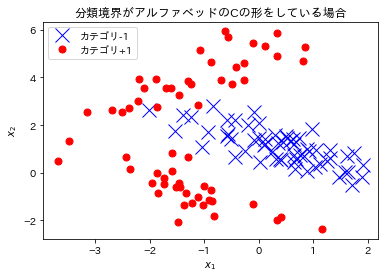

In [6]:
# データの可視化
plt.plot(X[Y[:,0]==-1,0],X[Y[:,0]==-1,1],'bx',markerSize=14,label="カテゴリ-1")
plt.plot(X[Y[:,0]== 1,0],X[Y[:,0]== 1,1],'r.',markerSize=14,label="カテゴリ+1")
plt.title('分類境界がアルファベッドのCの形をしている場合')
plt.xlabel(xLabel)
plt.ylabel(yLabel)
plt.legend()

In [7]:
# データを訓練と評価用に分割
dtrNum = int(len(X)*0.9)    # 学習データ数

# 訓練データ 全体の90%
X_train = X[:dtrNum]
y_train = Y[:dtrNum]
# 評価データ
X_test = X[dtrNum:]
y_test = Y[dtrNum:]

In [8]:
# 標準化
xMean = np.mean(X_train,axis=0)
xStd = np.std(X_train,axis=0)

X_train = (X_train-xMean) / xStd
X_test = (X_test-xMean) / xStd

In [9]:
class kernelFunc():
    def __init__(self,kernelType=0,kernelParam=1):
        """
        args:
            kernelType: 
                線形カーネル(0),ガウスカーネル(1)、多項式カーネル(2)
            kernelParam:
                カーネルの作成に用いるパラメータ（スカラー）
        """
        self.kernelType = kernelType
        self.kernelParam = kernelParam

        # カーネル関数の設定
        kernelFuncs = [self.linear,self.gauss,self.poly]
        self.createMatrix = kernelFuncs[kernelType]

    def linear(self,X1,X2):
        """線形カーネル"""
        return np.matmul(X1,X2.T)

    def gauss(self,X1,X2):
        """
        ガウスカーネル
        args:
            X1: 
                入力データ（データ数×次元数のnumpy.ndarray）
            X2:
                入力データ（データ数×次元数のnumpy.ndarray）
        """
        X1Num = len(X1)
        X2Num = len(X2)
        
        # X1とX2の全ペア間の距離の計算
        X1 = np.tile(np.expand_dims(X1.T,axis=2),[1,1,X2Num])
        X2 = np.tile(np.expand_dims(X2.T,axis=1),[1,X1Num,1])
        dist = np.sum(np.square(X1-X2),axis=0)
        
        # グラム行列（X1のデータ数×X2のデータ数）
        K = np.exp(-dist/(2*(self.kernelParam**2)))
        
        return K

    def poly(self,X1,X2):
        """
        多項式カーネル
        args:
            X1: 
                入力データ（データ数×次元数のnumpy.ndarray）
            X2:
                入力データ（データ数×次元数のnumpy.ndarray）
        """
        # グラム行列（X1のデータ数×X2のデータ数）
        K = (np.matmul(X1,X2.T)+1)**self.kernelParam

        return K

In [10]:
# カーネル関数の作成
myKernel = kernelFunc(kernelType=1,kernelParam=1)

In [11]:
class SVM():
    """SVM"""
    def __init__(self,X,Y,spptThre=0.1,kernelFunc=None):
        """
        args:
            x: 
                入力データ（データ数×次元数のnumpy.ndarray）
            y:
                出力データ（データ数×1のnumpy.ndarray）
            kernelFunc:
                kernelFuncクラスのインスタンス
        """
        # カーネルの設定
        self.kernelFunc = kernelFunc
        
        # 学習データの設定
        self.X = X
        self.Y = Y
        self.dNum = X.shape[0]  # 学習データ数
        self.xDim = X.shape[1]  # 入力の次元数
        
        # サポートベクトルの閾値設定
        self.spptThre = 0.1

    def trainSoft(self,C=0.1):
        """
        ソフトマージンSVMのモデルパラメータを最適化
        args:
            C: 
                誤差の重要度ハイパーパラメータ（スカラー、デフォルトでは0.1）
        """
        X = self.kernelFunc.createMatrix(self.X,self.X)
        
        # 行列Pの作成
        P = np.matmul(self.Y,self.Y.T) * X
        P = cvxopt.matrix(P)
        
        # q,G,h,A,bを作成
        q = cvxopt.matrix(-np.ones(self.dNum))
        G1 = np.diag(-np.ones(self.dNum))
        G2 = np.diag(np.ones(self.dNum))
        G = cvxopt.matrix(np.concatenate([G1,G2],axis=0))
        h1 = np.zeros([self.dNum,1])
        h2 = C * np.ones([self.dNum,1])
        h = cvxopt.matrix(np.concatenate([h1,h2],axis=0))
        A = cvxopt.matrix(self.Y.astype(float).T)
        b = cvxopt.matrix(0.0)

        # 凸二次計画法
        sol = cvxopt.solvers.qp(P,q,G,h,A,b)
        self.lamb = np.array(sol['x'])
        # 'x'がlambdaに対応する
        
        # サポートベクトルのインデックス
        self.spptInds = np.where(self.lamb>self.spptThre)[0]
        
        # wとbの計算
        self.w = np.matmul((self.lamb*self.Y).T,X).T
        self.b = np.mean(self.Y[self.spptInds]-np.matmul(X[self.spptInds,:],self.w))
    
    def predict(self,x):
        """
        予測
        args:
            X: 
                入力データ（データ数×次元数のnumpy.ndarray）
        """
        x = self.kernelFunc.createMatrix(x,self.X)
        y = np.matmul(x,self.w) + self.b
        return np.sign(y),y

    def accuracy(self,X,Y):
        """
        正解率の計算
        args:
            X: 
                入力データ（データ数×次元数のnumpy.ndarray）
            Y:
                出力データ（データ数×１のnumpy.ndarray）
        """
        predict,_ = self.predict(X)
        return np.sum(predict==Y)/len(X)

    def plotModel2D(self,X=[],Y=[],spptInds=[],xLabel='',yLabel='',title='',fName='',isLinePlot=False):
        '''
        真値と予測値のプロット（入力ベクトルが2次元の場合）
        args:
            X:
                入力データ（データ数×次元数のnumpy.ndarray）
            Y:
                出力データ（データ数×１のnumpy.ndarray）
            spptInds:
                サポートベクトルのインデックス（インデックス数のnumpy.ndarray)
            xLabel:
                x軸のラベル（文字列）
            yLabel:
                y軸のラベル（文字列）
            title:
                タイトル（文字列）
            fName:
                画像の保存先（文字列）
            isLinePlot：
                分類境界の直線をプロットするかしないか（boolean)
        '''
        plt.close()
        
        # 真値のプロット（クラスごとにマーカーを変更）
        plt.plot(X[Y[:,0]==-1,0],X[Y[:,0]==-1,1],'cx',markerSize=14,label="カテゴリ-1")
        plt.plot(X[Y[:,0]== 1,0],X[Y[:,0]== 1,1],'m.',markerSize=14,label="カテゴリ+1")

        # 予測値のメッシュの計算
        X1,X2 = plab.meshgrid(plab.linspace(np.min(X[:,0]),np.max(X[:,0]),50),plab.linspace(np.min(X[:,1]),np.max(X[:,1]),50))
        Xmesh = np.hstack([np.reshape(X1,[-1,1]),np.reshape(X2,[-1,1])])
        _,Ymesh = self.predict(Xmesh)
        Ymesh = np.reshape(Ymesh,X1.shape)

        # contourプロット
        CS = plt.contourf(X1,X2,Ymesh,linewidths=2,cmap="bwr",alpha=0.3,vmin=-5,vmax=5)

        # カラーバー
        CB = plt.colorbar(CS)
        CB.ax.tick_params(labelsize=14)
        
        # サポートベクトルのプロット
        if len(spptInds):
            plt.plot(X[spptInds,0],X[spptInds,1],'o',color='none',markeredgecolor='r',markersize=18,markeredgewidth=3,label="サポートベクトル")

        # 直線のプロット
        if isLinePlot:
            x1 = np.arange(np.min(X[:,0]),np.max(X[:,0]),(np.max(X[:,0]) - np.min(X[:,0]))/100)
            x2 = -(x1*self.w[0]+self.b)/self.w[1]
            plt.plot(x1,x2,'r-',label="f(x)")

        # 各軸の範囲、タイトルおよびラベルの設定
        plt.xlim([np.min(X[:,0]),np.max(X[:,0])])
        plt.ylim([np.min(X[:,1]),np.max(X[:,1])])
        plt.title(title,fontSize=14)
        plt.xlabel(xLabel,fontSize=14)
        plt.ylabel(yLabel,fontSize=14)
        plt.legend()

        # グラフの表示またはファイルへの保存
        if len(fName):
            plt.savefig(fName)
        else:
            plt.show()
        

In [12]:
# SVMのモデルの学習
myModel = SVM(X_train,y_train,kernelFunc=myKernel)
myModel.trainSoft(0.5)

     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  3e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  4e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  3e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  2e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  7e-16  3e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  2e-16  3e-16
Optimal solution found.


In [13]:
# SVMモデルの評価
print(f"モデルパラメータ:\nw={myModel.w}\nb={myModel.b}")
print(f"評価データの正解率={myModel.accuracy(X_test,y_test):.2f}")

モデルパラメータ:
w=[[ 0.30181711]
 [-1.66131483]
 [ 0.46418754]
 [ 0.491329  ]
 [-1.83495046]
 [ 0.35114321]
 [-1.97697964]
 [ 0.60930986]
 [ 0.59615865]
 [-1.52094146]
 [ 0.444239  ]
 [-1.75561578]
 [ 0.33868517]
 [-1.4293765 ]
 [ 0.22352007]
 [ 0.50154667]
 [ 0.33868531]
 [-1.59295984]
 [ 0.67706983]
 [ 0.1319347 ]
 [ 0.6493725 ]
 [ 0.07477204]
 [-1.83671059]
 [ 0.71473782]
 [ 0.05385069]
 [-2.01030664]
 [-1.70198781]
 [-1.95461335]
 [ 0.41569061]
 [ 0.92352728]
 [-2.03342489]
 [ 0.93462514]
 [ 0.60772211]
 [ 0.81975216]
 [-2.00774463]
 [ 0.34524202]
 [ 0.80062887]
 [-1.90969296]
 [ 0.61529709]
 [ 0.60918274]
 [-2.00242698]
 [-1.71696983]
 [-0.72016581]
 [ 0.36348612]
 [-1.75936927]
 [ 0.31247134]
 [-1.41472014]
 [-0.46463384]
 [-1.86844919]
 [ 0.80405692]
 [ 0.40733421]
 [-2.03709513]
 [-1.84041783]
 [ 0.42933594]
 [ 0.33868527]
 [-1.84020308]
 [-2.02034325]
 [ 0.90667649]
 [ 0.33868523]
 [ 0.88289048]
 [-2.05582273]
 [-1.42627412]
 [-1.98270315]
 [-1.2955024 ]
 [ 0.33868518]
 [-1.96710276

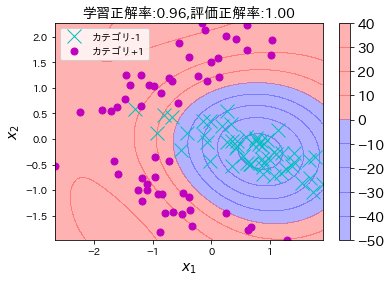

In [14]:
# 真値と予測値のプロット
myModel.plotModel2D(X=X_train,Y=y_train,xLabel=xLabel,yLabel=yLabel,
    title=f"学習正解率:{myModel.accuracy(X_train,y_train):.2f},評価正解率:{myModel.accuracy(X_test,y_test):.2f}",
    fName=f"../results/kernelSVM_result_{dataType}_{myKernel.kernelType}_{str(myKernel.kernelParam).replace('.','')}.pdf",
    isLinePlot=False)

--------------------線形カーネル--------------------
     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  2e-16  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  6e-16  9e-16
 4: -2.5651e+01 -2.6790e+01  1e+00  9e-16  8e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  1e-15  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  8e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  1e-15  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  8e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  7e-16  8e-16
Optimal solution found.


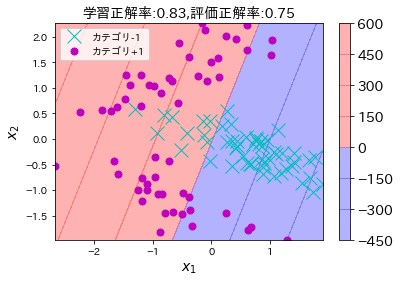

--------------------ガウスカーネル--------------------
sigma: 0.8
     pcost       dcost       gap    pres   dres
 0: -1.0552e+01 -1.0126e+02  7e+02  5e+00  4e-16
 1: -6.2167e+00 -7.3136e+01  7e+01  4e-02  5e-16
 2: -7.5202e+00 -1.7743e+01  1e+01  5e-03  4e-16
 3: -8.8890e+00 -1.0907e+01  2e+00  6e-04  2e-16
 4: -9.4395e+00 -9.9802e+00  5e-01  3e-05  2e-16
 5: -9.5777e+00 -9.6768e+00  1e-01  2e-06  2e-16
 6: -9.6085e+00 -9.6290e+00  2e-02  2e-07  2e-16
 7: -9.6162e+00 -9.6183e+00  2e-03  2e-08  2e-16
 8: -9.6171e+00 -9.6171e+00  4e-05  2e-10  3e-16
 9: -9.6171e+00 -9.6171e+00  8e-07  2e-12  3e-16
Optimal solution found.


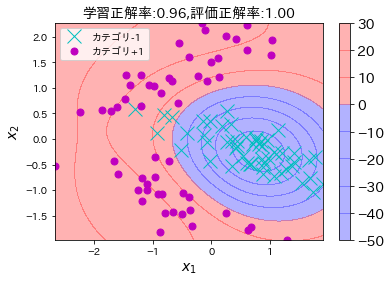

sigma: 1
     pcost       dcost       gap    pres   dres
 0: -1.1928e+01 -1.0335e+02  8e+02  5e+00  3e-16
 1: -6.8273e+00 -7.5274e+01  7e+01  6e-02  5e-16
 2: -8.0934e+00 -1.8491e+01  1e+01  8e-03  4e-16
 3: -9.6286e+00 -1.2497e+01  3e+00  2e-03  3e-16
 4: -1.0200e+01 -1.1242e+01  1e+00  4e-04  3e-16
 5: -1.0460e+01 -1.0759e+01  3e-01  8e-05  2e-16
 6: -1.0545e+01 -1.0619e+01  7e-02  2e-05  3e-16
 7: -1.0572e+01 -1.0578e+01  7e-03  4e-07  3e-16
 8: -1.0574e+01 -1.0575e+01  2e-04  7e-16  3e-16
 9: -1.0575e+01 -1.0575e+01  3e-06  2e-16  3e-16
Optimal solution found.


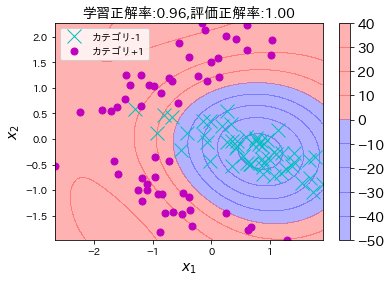

sigma: 3
     pcost       dcost       gap    pres   dres
 0: -3.3036e+01 -1.2324e+02  8e+02  5e+00  1e-15
 1: -2.0538e+01 -9.7623e+01  8e+01  7e-03  8e-16
 2: -2.2884e+01 -3.1441e+01  9e+00  8e-04  6e-16
 3: -2.5908e+01 -2.7611e+01  2e+00  1e-04  6e-16
 4: -2.6707e+01 -2.6950e+01  2e-01  1e-05  6e-16
 5: -2.6798e+01 -2.6859e+01  6e-02  3e-06  6e-16
 6: -2.6828e+01 -2.6832e+01  4e-03  4e-16  9e-16
 7: -2.6830e+01 -2.6830e+01  5e-04  1e-15  7e-16
 8: -2.6830e+01 -2.6830e+01  5e-05  2e-15  6e-16
 9: -2.6830e+01 -2.6830e+01  5e-07  9e-16  7e-16
Optimal solution found.


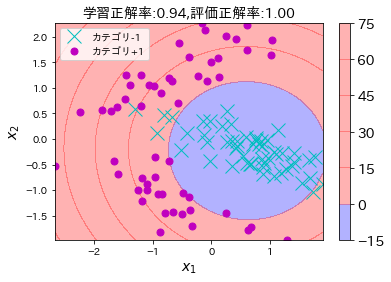

--------------------多項式カーネル--------------------
p: 1
     pcost       dcost       gap    pres   dres
 0: -4.8075e+01 -1.3210e+02  1e+03  6e+00  2e-15
 1: -2.3552e+01 -1.0541e+02  1e+02  4e-01  2e-15
 2: -2.1211e+01 -3.5011e+01  1e+01  3e-16  1e-15
 3: -2.4724e+01 -2.7852e+01  3e+00  9e-16  1e-15
 4: -2.5651e+01 -2.6790e+01  1e+00  6e-16  9e-16
 5: -2.6017e+01 -2.6339e+01  3e-01  8e-16  1e-15
 6: -2.6144e+01 -2.6193e+01  5e-02  6e-16  9e-16
 7: -2.6163e+01 -2.6171e+01  8e-03  6e-16  1e-15
 8: -2.6167e+01 -2.6167e+01  2e-04  2e-16  1e-15
 9: -2.6167e+01 -2.6167e+01  2e-06  4e-16  1e-15
Optimal solution found.


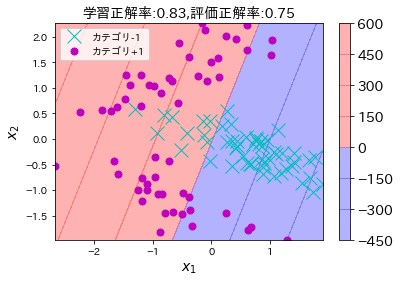

p: 2
     pcost       dcost       gap    pres   dres
 0: -1.7408e+01 -1.0521e+02  9e+02  5e+00  5e-15
 1: -8.5213e+00 -7.5968e+01  2e+02  7e-01  4e-15
 2: -4.8772e+00 -3.0582e+01  4e+01  1e-01  5e-15
 3: -4.2849e+00 -1.1352e+01  9e+00  2e-02  2e-15
 4: -4.9700e+00 -7.4521e+00  3e+00  6e-03  1e-15
 5: -5.3798e+00 -6.2923e+00  1e+00  2e-03  1e-15
 6: -5.5150e+00 -5.9036e+00  4e-01  2e-16  2e-15
 7: -5.6384e+00 -5.7380e+00  1e-01  2e-16  2e-15
 8: -5.6692e+00 -5.6924e+00  2e-02  2e-16  1e-15
 9: -5.6788e+00 -5.6816e+00  3e-03  4e-16  2e-15
10: -5.6801e+00 -5.6802e+00  8e-05  3e-16  2e-15
11: -5.6801e+00 -5.6801e+00  8e-07  2e-16  2e-15
Optimal solution found.


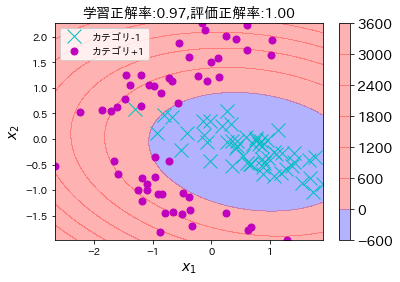

p: 4
     pcost       dcost       gap    pres   dres
 0: -9.0418e+00 -9.2075e+01  7e+02  5e+00  7e-14
 1: -4.6100e+00 -6.1111e+01  1e+02  4e-01  4e-14
 2: -3.5817e+00 -2.5295e+01  3e+01  1e-01  2e-14
 3: -3.3415e+00 -1.3671e+01  2e+01  5e-02  2e-14
 4: -3.1166e+00 -7.8912e+00  7e+00  2e-02  9e-15
 5: -2.7559e+00 -4.2102e+00  2e+00  4e-03  1e-14
 6: -2.7962e+00 -3.1247e+00  4e-01  8e-04  9e-15
 7: -2.8197e+00 -2.9095e+00  1e-01  1e-04  8e-15
 8: -2.8351e+00 -2.8597e+00  3e-02  2e-05  9e-15
 9: -2.8434e+00 -2.8446e+00  1e-03  1e-07  6e-15
10: -2.8439e+00 -2.8440e+00  3e-05  3e-09  9e-15
11: -2.8440e+00 -2.8440e+00  8e-07  5e-11  8e-15
Optimal solution found.


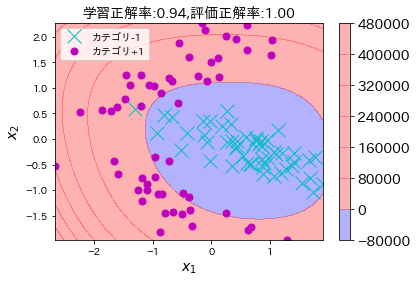

In [15]:
for k_type in range(3):
    k_type_name = ''
    if k_type == 0:
        k_type_name = '線形カーネル'
    elif k_type == 1:
        k_type_name = 'ガウスカーネル'
    else:
        k_type_name = '多項式カーネル'
        
    print('-'*20+f'{k_type_name}'+'-'*20)
    if k_type == 0:
        # カーネル関数の作成
        myKernel = kernelFunc(kernelType=k_type,kernelParam=1)
        # SVMのモデルの学習
        myModel = SVM(X_train,y_train,kernelFunc=myKernel)
        myModel.trainSoft(0.5)

        # 真値と予測値のプロット
        myModel.plotModel2D(X=X_train,Y=y_train,xLabel=xLabel,yLabel=yLabel,
            title=f"学習正解率:{myModel.accuracy(X_train,y_train):.2f},評価正解率:{myModel.accuracy(X_test,y_test):.2f}",
            fName=f"../results/kernelSVM_result_{dataType}_{myKernel.kernelType}_{str(myKernel.kernelParam).replace('.','')}.pdf",
            isLinePlot=False)
        plt.show()
    
    elif k_type == 1:
        for sigma in [0.8, 1, 3]:
            print(f'sigma: {sigma}')
            # カーネル関数の作成
            myKernel = kernelFunc(kernelType=k_type,kernelParam=sigma)
            
            # SVMのモデルの学習
            myModel = SVM(X_train,y_train,kernelFunc=myKernel)
            myModel.trainSoft(0.5)

            # 真値と予測値のプロット
            myModel.plotModel2D(X=X_train,Y=y_train,xLabel=xLabel,yLabel=yLabel,
                title=f"学習正解率:{myModel.accuracy(X_train,y_train):.2f},評価正解率:{myModel.accuracy(X_test,y_test):.2f}",
                fName=f"../results/kernelSVM_result_{dataType}_{myKernel.kernelType}_{str(myKernel.kernelParam).replace('.','')}.pdf",
                isLinePlot=False)
            plt.show()
    else:
        for p in [1, 2, 4]:
            print(f'p: {p}')
            # カーネル関数の作成
            myKernel = kernelFunc(kernelType=k_type,kernelParam=p)
            
            # SVMのモデルの学習
            myModel = SVM(X_train,y_train,kernelFunc=myKernel)
            myModel.trainSoft(0.5)

            # 真値と予測値のプロット
            myModel.plotModel2D(X=X_train,Y=y_train,xLabel=xLabel,yLabel=yLabel,
                title=f"学習正解率:{myModel.accuracy(X_train,y_train):.2f},評価正解率:{myModel.accuracy(X_test,y_test):.2f}",
                fName=f"../results/kernelSVM_result_{dataType}_{myKernel.kernelType}_{str(myKernel.kernelParam).replace('.','')}.pdf",
                isLinePlot=False)
            plt.show()


In [16]:
# データの生成
np.random.seed(1)
dataType = 5

# トイデータ 複数の島がある場合
negLabel = -1.0
posLabel = 1.0

dNum = 120

cov = [[1,-0.8],[-0.8,1]]
X = np.random.multivariate_normal([0.5,1],cov,int(dNum/2))
X = np.concatenate([X,np.random.multivariate_normal([-1,-1],cov,int(dNum/4))],axis=0)
X = np.concatenate([X,np.random.multivariate_normal([2,2],cov,int(dNum/4))],axis=0)
Y = np.concatenate([negLabel*np.ones([int(dNum/2),1]),posLabel*np.ones([int(dNum/2),1])],axis=0)

# データのインデックスをシャッフル
randInds = np.random.permutation(dNum)
X = X[randInds]
Y = Y[randInds]
xLabel = '$x_1$'
yLabel = '$x_2$'

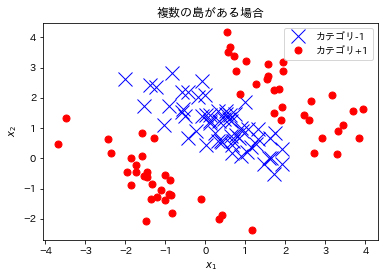

In [17]:
# データの可視化
plt.plot(X[Y[:,0]==-1,0],X[Y[:,0]==-1,1],'bx',markerSize=14,label="カテゴリ-1")
plt.plot(X[Y[:,0]== 1,0],X[Y[:,0]== 1,1],'r.',markerSize=14,label="カテゴリ+1")
plt.title('複数の島がある場合')
plt.xlabel(xLabel)
plt.ylabel(yLabel)
plt.legend()

In [18]:
# データを訓練と評価用に分割
dtrNum = int(len(X)*0.9)    # 学習データ数

# 訓練データ 全体の90%
X_train = X[:dtrNum]
y_train = Y[:dtrNum]
# 評価データ
X_test = X[dtrNum:]
y_test = Y[dtrNum:]

In [19]:
# 標準化
xMean = np.mean(X_train,axis=0)
xStd = np.std(X_train,axis=0)

X_train = (X_train-xMean) / xStd
X_test = (X_test-xMean) / xStd

--------------------線形カーネル--------------------
     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  3e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  6e-16  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  2e-15  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  9e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  2e-16  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  7e-16  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  2e-15  1e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  8e-16  1e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  8e-16  1e-15
Optimal solution found.


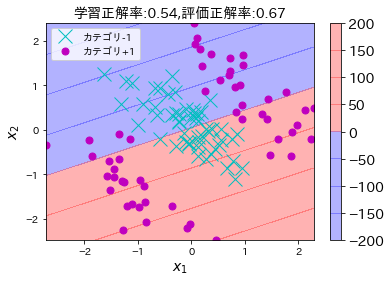

--------------------ガウスカーネル--------------------
sigma: 0.5
     pcost       dcost       gap    pres   dres
 0: -9.6721e+00 -8.1636e+01  5e+02  3e+00  3e-16
 1: -7.1474e+00 -5.6000e+01  5e+01  5e-16  4e-16
 2: -8.7156e+00 -1.5288e+01  7e+00  6e-16  3e-16
 3: -9.8173e+00 -1.1606e+01  2e+00  4e-16  2e-16
 4: -1.0230e+01 -1.0705e+01  5e-01  2e-16  2e-16
 5: -1.0344e+01 -1.0473e+01  1e-01  1e-16  2e-16
 6: -1.0386e+01 -1.0397e+01  1e-02  2e-16  2e-16
 7: -1.0390e+01 -1.0390e+01  5e-04  4e-16  2e-16
 8: -1.0390e+01 -1.0390e+01  1e-05  6e-16  2e-16
 9: -1.0390e+01 -1.0390e+01  3e-07  2e-16  2e-16
Optimal solution found.


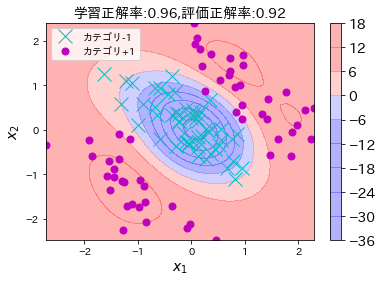

sigma: 1
     pcost       dcost       gap    pres   dres
 0: -1.1078e+01 -8.5081e+01  5e+02  4e+00  4e-16
 1: -7.2142e+00 -5.8832e+01  5e+01  5e-16  4e-16
 2: -8.9698e+00 -1.5624e+01  7e+00  3e-16  4e-16
 3: -1.0419e+01 -1.2351e+01  2e+00  3e-16  3e-16
 4: -1.0931e+01 -1.1488e+01  6e-01  6e-16  3e-16
 5: -1.1095e+01 -1.1220e+01  1e-01  2e-16  3e-16
 6: -1.1140e+01 -1.1156e+01  2e-02  4e-16  3e-16
 7: -1.1146e+01 -1.1147e+01  6e-04  4e-16  3e-16
 8: -1.1147e+01 -1.1147e+01  1e-05  2e-16  3e-16
Optimal solution found.


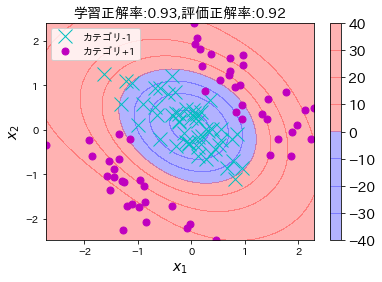

sigma: 2
     pcost       dcost       gap    pres   dres
 0: -2.5940e+01 -1.0607e+02  6e+02  4e+00  9e-16
 1: -1.8220e+01 -8.1863e+01  6e+01  5e-16  7e-16
 2: -2.0310e+01 -2.7644e+01  7e+00  2e-16  6e-16
 3: -2.2674e+01 -2.4358e+01  2e+00  3e-16  6e-16
 4: -2.3429e+01 -2.3678e+01  2e-01  3e-16  6e-16
 5: -2.3542e+01 -2.3589e+01  5e-02  9e-16  6e-16
 6: -2.3566e+01 -2.3568e+01  2e-03  1e-15  7e-16
 7: -2.3567e+01 -2.3567e+01  4e-05  6e-16  7e-16
 8: -2.3567e+01 -2.3567e+01  1e-06  1e-15  6e-16
Optimal solution found.


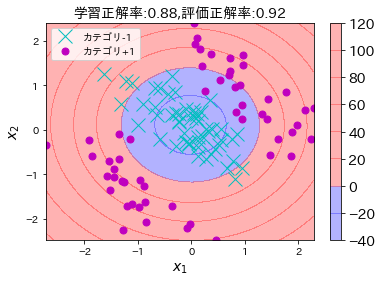

--------------------多項式カーネル--------------------
p: 1
     pcost       dcost       gap    pres   dres
 0: -7.9265e+01 -1.1936e+02  6e+02  4e+00  4e-15
 1: -4.0763e+01 -9.7983e+01  6e+01  2e-15  2e-15
 2: -4.6745e+01 -5.5219e+01  8e+00  2e-15  1e-15
 3: -4.8837e+01 -5.2275e+01  3e+00  9e-16  1e-15
 4: -4.9985e+01 -5.0722e+01  7e-01  3e-16  1e-15
 5: -5.0218e+01 -5.0405e+01  2e-01  1e-15  1e-15
 6: -5.0286e+01 -5.0318e+01  3e-02  1e-15  2e-15
 7: -5.0301e+01 -5.0301e+01  3e-04  6e-16  2e-15
 8: -5.0301e+01 -5.0301e+01  3e-06  8e-16  1e-15
Optimal solution found.


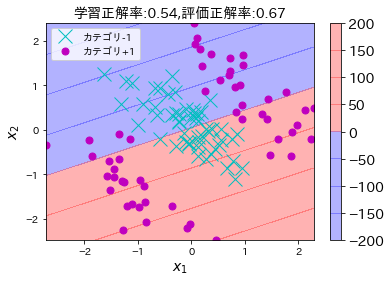

p: 2
     pcost       dcost       gap    pres   dres
 0: -2.3095e+01 -1.2900e+02  1e+03  6e+00  7e-15
 1: -1.0663e+01 -9.9291e+01  2e+02  9e-01  6e-15
 2: -4.6725e+00 -4.2304e+01  6e+01  2e-01  8e-15
 3: -3.3165e+00 -1.1923e+01  1e+01  3e-02  2e-15
 4: -3.9023e+00 -7.5850e+00  4e+00  8e-03  2e-15
 5: -4.3994e+00 -6.0987e+00  2e+00  2e-03  1e-15
 6: -4.6856e+00 -5.4185e+00  8e-01  5e-04  1e-15
 7: -4.8525e+00 -5.1374e+00  3e-01  1e-04  1e-15
 8: -4.9294e+00 -5.0075e+00  8e-02  3e-05  1e-15
 9: -4.9564e+00 -4.9604e+00  4e-03  2e-16  1e-15
10: -4.9583e+00 -4.9584e+00  4e-05  4e-16  1e-15
11: -4.9584e+00 -4.9584e+00  4e-07  2e-16  1e-15
Optimal solution found.


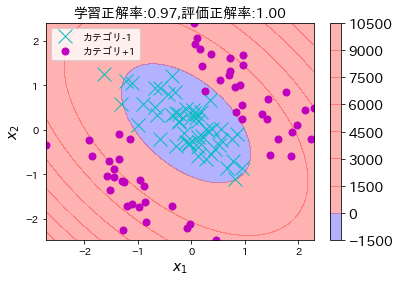

p: 3
     pcost       dcost       gap    pres   dres
 0: -2.0462e+01 -1.0525e+02  8e+02  5e+00  4e-14
 1: -1.0162e+01 -7.6637e+01  2e+02  8e-01  2e-14
 2: -5.4797e+00 -3.6663e+01  6e+01  2e-01  1e-14
 3: -3.4208e+00 -1.4841e+01  2e+01  8e-02  5e-15
 4: -2.4488e+00 -6.8490e+00  7e+00  2e-02  5e-15
 5: -2.5496e+00 -3.8843e+00  2e+00  4e-03  3e-15
 6: -2.6700e+00 -3.2794e+00  6e-01  3e-04  2e-15
 7: -2.8168e+00 -2.9227e+00  1e-01  4e-05  2e-15
 8: -2.8528e+00 -2.8671e+00  1e-02  2e-06  2e-15
 9: -2.8586e+00 -2.8593e+00  7e-04  7e-08  2e-15
10: -2.8589e+00 -2.8589e+00  7e-06  7e-10  2e-15
11: -2.8589e+00 -2.8589e+00  7e-08  7e-12  2e-15
Optimal solution found.


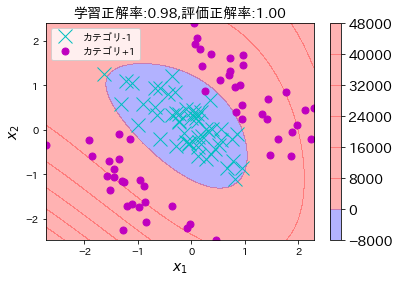

In [20]:
for k_type in range(3):
    k_type_name = ''
    if k_type == 0:
        k_type_name = '線形カーネル'
    elif k_type == 1:
        k_type_name = 'ガウスカーネル'
    else:
        k_type_name = '多項式カーネル'
        
    print('-'*20+f'{k_type_name}'+'-'*20)
    if k_type == 0:
        # カーネル関数の作成
        myKernel = kernelFunc(kernelType=k_type,kernelParam=1)
        # SVMのモデルの学習
        myModel = SVM(X_train,y_train,kernelFunc=myKernel)
        myModel.trainSoft(0.5)

        # 真値と予測値のプロット
        myModel.plotModel2D(X=X_train,Y=y_train,xLabel=xLabel,yLabel=yLabel,
            title=f"学習正解率:{myModel.accuracy(X_train,y_train):.2f},評価正解率:{myModel.accuracy(X_test,y_test):.2f}",
            fName=f"../results/kernelSVM_result_{dataType}_{myKernel.kernelType}_{str(myKernel.kernelParam).replace('.','')}.pdf",
            isLinePlot=False)
        plt.show()
    
    elif k_type == 1:
        for sigma in [0.5, 1, 2]:
            print(f'sigma: {sigma}')
            # カーネル関数の作成
            myKernel = kernelFunc(kernelType=k_type,kernelParam=sigma)
            
            # SVMのモデルの学習
            myModel = SVM(X_train,y_train,kernelFunc=myKernel)
            myModel.trainSoft(0.5)

            # 真値と予測値のプロット
            myModel.plotModel2D(X=X_train,Y=y_train,xLabel=xLabel,yLabel=yLabel,
                title=f"学習正解率:{myModel.accuracy(X_train,y_train):.2f},評価正解率:{myModel.accuracy(X_test,y_test):.2f}",
                fName=f"../results/kernelSVM_result_{dataType}_{myKernel.kernelType}_{str(myKernel.kernelParam).replace('.','')}.pdf",
                isLinePlot=False)
            plt.show()
    else:
        for p in [1, 2, 3]:
            print(f'p: {p}')
            # カーネル関数の作成
            myKernel = kernelFunc(kernelType=k_type,kernelParam=p)
            
            # SVMのモデルの学習
            myModel = SVM(X_train,y_train,kernelFunc=myKernel)
            myModel.trainSoft(0.5)

            # 真値と予測値のプロット
            myModel.plotModel2D(X=X_train,Y=y_train,xLabel=xLabel,yLabel=yLabel,
                title=f"学習正解率:{myModel.accuracy(X_train,y_train):.2f},評価正解率:{myModel.accuracy(X_test,y_test):.2f}",
                fName=f"../results/kernelSVM_result_{dataType}_{myKernel.kernelType}_{str(myKernel.kernelParam).replace('.','')}.pdf",
                isLinePlot=False)
            plt.show()
